In [2]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os
import cv2
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
import itertools
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

In [3]:
orig_data=np.load("../../data/omniglot_npy/data.npy")

In [4]:
# META_BATCH_SIZE=32
# meta_batch=np.random.rand(BATCH_SIZE,ways,64,64,3)
# ans=np.array([np.random.permutation(np.eye(ways,ways)) for _ in range(BATCH_SIZE)])
# meta_batch=meta_batch.transpose(1,0,2,3,4)
# ans=ans.transpose(1,0,2)

In [5]:
class DataGenerator(utils.Sequence):
    def __init__(self,data,way,shot,cls_list,batch_size=32,shuffle=False):
        super().__init__()
        self.n_samples=len(cls_list)
        self.dataset=np.empty((self.n_samples,way*shot,28,28,1))
        self.labels=np.empty((self.n_samples,way*shot))
        self.batch_size=batch_size
        self.shuffle=shuffle
#         self.way=way
        amnt_per_cls=data.shape[1]
        count = 0
        for ii in range(self.n_samples):
            d_sel=[]
            l_sel=(np.random.rand(way*shot)*20).astype(int)
            w_list=np.random.permutation(list(range(way))*shot)
            for jj,ww in enumerate(w_list):
                d_sel.append(data[cls_list[ii][ww],l_sel[jj],...])
                
            d_sel=np.stack(d_sel)
            self.dataset[count,...,0]=d_sel
            self.labels[count,...]=np.array(w_list)
                
            count+=1
    def __len__(self):
        return self.n_samples//self.batch_size
    def __getitem__(self,index):
        x=self.dataset[index*self.batch_size:(index+1)*self.batch_size]/255.-0.5
        y=self.labels[index*self.batch_size:(index+1)*self.batch_size]
        return x,y
    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        if self.shuffle:
            order=np.random.permutation(self.n_samples)
            self.dataset=self.dataset[order]
            self.labels=self.labels[order]
        for item in (self[i] for i in range(len(self))):
            yield item

In [6]:
way =3
shot = 7
query = 1
max_epoch = 40
inner_train_step = 1
META_BATCH_SIZE=128
eval_batches = test_batches = 20
total_samples=10000

In [7]:
list_all=np.random.permutation(len(orig_data))
cls_list=[]
for _ in range(total_samples//(len(orig_data)//way*way)):
    for ii in range(way):
        list_all=np.random.permutation(list_all)
        for jj in range(len(orig_data)//way):
            cls_list.append(list_all[(jj*way):(jj+1)*way])
total_samples=len(cls_list)
train_list,val_lsit=cls_list[:total_samples//10*8],cls_list[total_samples//10*8:]

gen_train = DataGenerator(orig_data,way, shot, batch_size=META_BATCH_SIZE,cls_list=train_list,shuffle=True)
gen_val = DataGenerator(orig_data,way, shot, batch_size=META_BATCH_SIZE, cls_list=val_lsit)
len(train_list), len(val_lsit),len(gen_train), len(gen_val)

(7784, 1954, 121, 30)

In [8]:
cnt=0
for meta_data,meta_label in gen_train:
    pass

In [9]:
# gp=1
# print("Support")
# plt.figure(figsize=(7*3,5*3))
# ee=1
# for ii in range(5):
#     for jj in range(7):
#         plt.subplot(5,7,ee)
#         plt.imshow(meta_data[gp,ii*7+jj,...,0],"gray")
#         plt.title(f"group{gp}:{meta_label[gp,ii*7+jj]}")
#         ee+=1
# plt.show()

In [10]:
class CNN_model(keras.Model):
    def __init__(self, N_HIDDEN,in_ch,num_cls):
        super().__init__()
        self.initializer = keras.initializers.HeNormal()
        self.block1 = self.build_block(N_HIDDEN,in_ch)
        self.block2 = self.build_block(N_HIDDEN,N_HIDDEN)
        self.gap=keras.layers.GlobalAveragePooling2D()
        self.flat = keras.layers.Flatten()
        self.out = keras.layers.Dense(num_cls, activation='softmax',kernel_initializer=self.initializer)
    def build_block(self,h_out,h_in):
        return keras.models.Sequential([
            keras.layers.Conv2D(h_out,h_in, padding='same',kernel_initializer=self.initializer),
            keras.layers.BatchNormalization(),
            keras.layers.Activation(keras.activations.relu),
            keras.layers.MaxPooling2D()])
    def call(self, x):
        x = self.block1(x)
        x = keras.layers.Dropout(0.2)(x)
        x = self.block2(x)
        x = keras.layers.Dropout(0.2)(x)
        x = self.gap(x)
        x = self.flat(x)
        y = self.out(x)
        return y
    
class LSTM_model(keras.Model):
    def __init__(self,n_units):
        super().__init__()
        self.initializer = keras.initializers.HeNormal()
        self.lstm1 = keras.layers.LSTMCell(n_units,dropout=0.2, recurrent_dropout=0.2,kernel_initializer=self.initializer)
        self.lstm2 = keras.layers.LSTMCell(n_units,dropout=0.2, recurrent_dropout=0.2,kernel_initializer=self.initializer)
        self.rnn= keras.layers.RNN([self.lstm1,self.lstm2],return_sequences=True,stateful=True)
        self.out=keras.layers.Dense(1,kernel_initializer=self.initializer)
    def call(self, x):
        x = self.rnn(x)
        y = self.out(x)
        return y

In [11]:
cnn=CNN_model(8,in_ch=1,num_cls=way)
lstm=LSTM_model(32)


In [12]:
def flat_tensors(tensors):
    tensors=tf.keras.layers.Concatenate()([tf.reshape(tens,-1) for tens in tensors])
    return tf.reshape(tensors,(len(tensors),1,1))
# def reshape_tensors_as(tensors,ref):
#     tensor_reshaped=[]
#     nn=0
#     for layer in ref:
#         flt_len=np.prod(layer.shape)
#         tensor_reshaped.append(tf.reshape(tensors[nn:nn+flt_len],layer.shape))
#         nn+=flt_len
#     return tensor_reshaped
def assign_sub(tensors,ref):
    nn=0
    for w in ref:
        flt_len=np.prod(w.shape)
        w.assign_add(tf.reshape(tensors[nn:nn+flt_len],w.shape))
        nn+=flt_len

In [13]:
# print(cnn.trainable_weights[0][0][0][0][0],cnn.trainable_weights[0][0][0][0][1])
# assign_sub(new_update,cnn.trainable_weights)
# print(cnn.trainable_weights[0][0][0][0][0],cnn.trainable_weights[0][0][0][0][1])

In [14]:
cnn.build((way,28,28,1))
cnn_param_num=sum([np.prod(ww.shape) for ww in cnn.trainable_weights])
lstm.build((cnn_param_num,1,1))
opt_rnn=keras.optimizers.Adam(lr=0.0001)
opt_cnn=keras.optimizers.Adam(lr=0.001)
acc_fn = keras.metrics.categorical_accuracy
cnn_loss_fn=keras.losses.categorical_crossentropy
lstm_loss_fn1=keras.losses.cosine_similarity
lstm_loss_fn2=keras.losses.mae

In [15]:
cnn_avg_w=[np.mean(ww) for ww in cnn.trainable_weights if len(ww.shape)>1]
lstm_avg_w=[np.mean(ww) for ww in lstm.trainable_weights if len(ww.shape)>1]

In [16]:
# train_loss_log = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy_log = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

# test_loss_log = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy_log = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

# @tf.function
# def train_step(meta_data, meta_label):
#     train_acc=[]
#     for ii,(data,label) in enumerate(zip(meta_data,meta_label)):
#         if ii==0:
#             flt_grads=np.random.rand(cnn_param_num,1,1)
#             for cell in lstm.rnn.states:
#                 for ss in cell:
#                     ss.assign(np.zeros(ss.shape))
#         else:
#             flt_grads=flat_tensors(grads1)
#         with tf.GradientTape() as tape2:
#             new_update=lstm(flt_grads)
#             assign_sub(new_update,cnn.trainable_weights)
#             with tf.GradientTape() as tape1:
#                 logits=cnn(data)
#                 loss1=cnn_loss_fn(label, logits)
#             grads1=tape1.gradient(loss1,cnn.trainable_weights)
#             flt_grads2=flat_tensors(grads1)
#             loss2=lstm_loss_fn(flt_grads2*meta_lr, new_update)
#         grads3=tape2.gradient(loss2,lstm.trainable_weights)
#         opt_rnn.apply_gradients(zip(grads3, lstm.trainable_weights))
#         acc=acc_fn(label.argmax(-1),logits).numpy().mean()
#         train_acc.append(acc)
#     train_loss_log(loss1)
#     train_accuracy_log(label, logits)

In [17]:
meta_lr=0.001
for epoch in range(max_epoch):
    train_sess=tqdm.tqdm(gen_train)
    val_sess=tqdm.tqdm(gen_val)
    for meta_data,meta_label in train_sess:
        
        meta_data=meta_data.transpose(1,0,2,3,4)
        meta_label=meta_label.transpose(1,0)
        
#         p = np.random.permutation(len(meta_label))
#         meta_data=meta_data[p]
#         meta_label=meta_label[p]
        
#         lstm.rnn.reset_states()
        train_acc=[]
#         for iter_ in range(10):
        for ii,(data,label) in enumerate(zip(meta_data,meta_label)):
            label_1_hot=tf.one_hot(label,depth=way)
            if ii==0:
                flt_grads=np.random.rand(cnn_param_num,1,1)
                for cell in lstm.rnn.states:
                    for ss in cell:
                        ss.assign(np.zeros(ss.shape))
            else:
                flt_grads=flt_grads2
            with tf.GradientTape(persistent=True) as tape2:
                new_update=lstm(flt_grads)
                assign_sub(new_update,cnn.trainable_weights)
                logits=cnn(data)
                
                loss1=cnn_loss_fn(label_1_hot, logits)+tf.sqrt(tf.reduce_mean(new_update**2))*0.5
            grads1=tape2.gradient(loss1,cnn.trainable_weights)    
            flt_grads2=flat_tensors(grads1)
#                 loss2=lstm_loss_fn1(flt_grads2, new_update)
#             grads3=tape2.gradient(loss2,lstm.trainable_weights)
            grads4=tape2.gradient(new_update,lstm.trainable_weights,output_gradients=flt_grads2)
            
            opt_rnn.apply_gradients(zip(grads4, lstm.trainable_weights))
#             opt_cnn.apply_gradients(zip(grads1, cnn.trainable_weights))
            acc=acc_fn(label,logits).numpy().mean()
            train_acc.append(acc)
            
        train_sess.set_postfix({"CNN loss": loss1.numpy().mean(),"acc":np.mean(train_acc)})
#     for meta_data,meta_label in gen_val:

AttributeError: 'function' object has no attribute 'tqdm'

In [19]:
flt_grads2

<tf.Tensor: shape=(4179, 1, 1), dtype=float32, numpy=
array([[[ 8.6045347e+11]],

       [[-3.7037592e+11]],

       [[ 9.3765966e+11]],

       ...,

       [[-2.8000000e+01]],

       [[ 3.3000000e+01]],

       [[-5.0000000e+00]]], dtype=float32)>

In [25]:
np.corrcoef(flt_grads2[:,0,0],new_update[:,0,0])

array([[1.        , 0.07009966],
       [0.07009966, 1.        ]])

Support


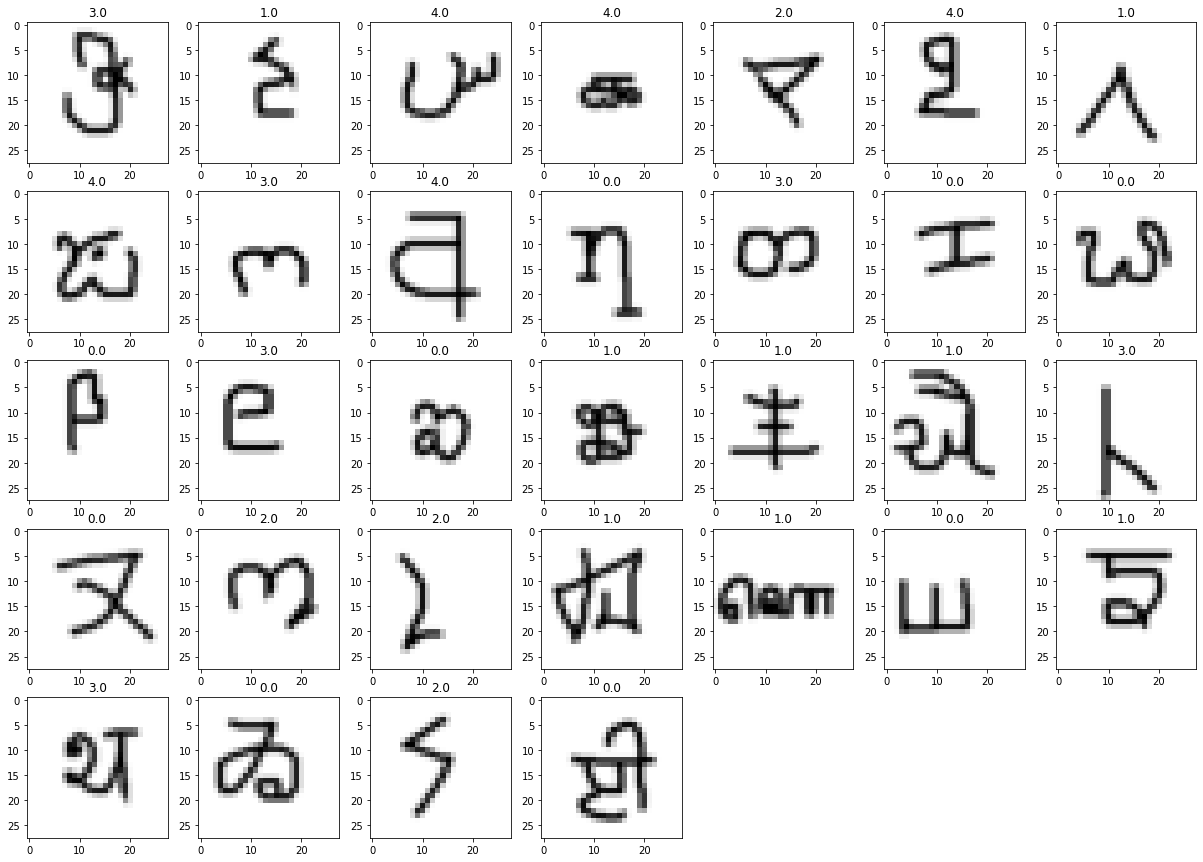

In [83]:
gp=1
print("Support")
plt.figure(figsize=(7*3,5*3))
ee=1
for ii in range(4):
    for jj in range(8):
        plt.subplot(5,7,ee)
        plt.imshow(data[ee-1,...,0],"gray")
        plt.title(f"{label[ee-1]}")
        ee+=1
plt.show()

# Normal way to 

In [ ]:
meta_lr=0.001
for epoch in range(max_epoch):
    train_sess=tqdm(gen_train)
    val_sess=tqdm(gen_val)
    for meta_data,meta_label in train_sess:
        
        meta_data=meta_data.transpose(1,0,2,3,4)
        meta_label=meta_label.transpose(1,0)
        
#         p = np.random.permutation(len(meta_label))
#         meta_data=meta_data[p]
#         meta_label=meta_label[p]
        
#         lstm.rnn.reset_states()
        train_acc=[]
        for ii,(data,label) in enumerate(zip(meta_data,meta_label)):
            label_1_hot=tf.one_hot(label,depth=way)
            with tf.GradientTape() as tape2:
                logits=cnn(data)
                loss1=cnn_loss_fn(label_1_hot, logits)+tf.sqrt(tf.reduce_mean(flat_tensors(cnn.trainable_weights)**2))*0.5
                
            grads1=tape2.gradient(loss1,cnn.trainable_weights)    
            opt_cnn.apply_gradients(zip(grads1, cnn.trainable_weights))
            acc=acc_fn(label,logits).numpy().mean()
            train_acc.append(acc)
            
        train_sess.set_postfix({"CNN loss": loss1.numpy().mean(),"acc":np.mean(train_acc)})
#     for meta_data,meta_label in gen_val:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [28]:
label_1_hot

<tf.Tensor: shape=(32, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

In [29]:
data.shape

(32, 28, 28, 1)

In [27]:
cnn_loss_fn(label_1_hot, logits)

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([1.8782846, 1.8532386, 1.6707168, 1.8532656, 1.3665987, 1.7594655,
       1.4885184, 1.8738458, 1.5027262, 1.5177   , 1.8696603, 1.5369011,
       1.487056 , 1.8928249, 1.8594495, 1.8797354, 1.366936 , 1.6254541,
       1.358476 , 1.7556998, 1.8470876, 1.4176798, 1.6033862, 1.8634678,
       1.778394 , 1.4584711, 1.6055138, 1.8886201, 1.8639201, 1.3709668,
       1.8886174, 1.8693851], dtype=float32)>

In [89]:
a=list(zip(meta_data,meta_label))
_=np.random.shuffle(a)


In [37]:
new_update

<tf.Tensor: shape=(413, 1, 1), dtype=float32, numpy=
array([[[ 0.01004287]],

       [[-0.00475765]],

       [[ 0.07600726]],

       [[ 0.00470769]],

       [[ 0.00415762]],

       [[-0.00598732]],

       [[ 0.07594351]],

       [[ 0.00480479]],

       [[ 0.00727777]],

       [[-0.00574929]],

       [[ 0.07591528]],

       [[ 0.00299898]],

       [[ 0.00661463]],

       [[-0.00500201]],

       [[ 0.07606812]],

       [[ 0.00731245]],

       [[ 0.00451137]],

       [[-0.00551645]],

       [[ 0.07575534]],

       [[ 0.00646296]],

       [[ 0.00964609]],

       [[-0.00549846]],

       [[ 0.0756444 ]],

       [[ 0.00885354]],

       [[ 0.01000279]],

       [[-0.00608149]],

       [[ 0.07594598]],

       [[ 0.0092102 ]],

       [[ 0.00364341]],

       [[-0.00578218]],

       [[ 0.0754975 ]],

       [[ 0.00358974]],

       [[ 0.00546485]],

       [[-0.00474221]],

       [[ 0.07531615]],

       [[ 0.00419098]],

       [[ 0.00459729]],

       [[-0.00562802]]

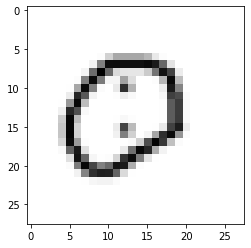

In [32]:
plt.imshow(data[3])

In [36]:
logits=cnn(data)

In [56]:
list(zip(meta_data,meta_label)).__len__()

40

In [25]:
logits.numpy().argmax(-1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [66]:
flt_grads=tf.Variable(np.zeros((cnn_param_num,1,1)))
for ii,(data,label) in enumerate(zip(meta_batch,ans)):
    lstm(flt_grads.numpy())
    
    with tf.GradientTape() as tape:
        logits=cnn(data)
        loss=tf.reduce_mean(keras.losses.categorical_crossentropy(label, logits))
    grads=tape.gradient(loss,cnn.trainable_weights)
    flt_grads=flat_tensors(grads)
    
    for ii==0:
        flt_grads=tf.Variables(np.zeros((cnn_param_num,1,1)))
        
    with tf.GradientTape() as tape2:
        update_val=lstm(flt_grads.numpy())
        assign_add(update_val[0],cnn.trainable_weights)
        logits=cnn(data)
        loss2=tf.reduce_mean(keras.losses.categorical_crossentropy(label, logits))
    grads2=tape2.gradient(loss2,cnn.trainable_weights)    
#     grads2=tape2.gradient(loss2,lstm.trainable_weights,outp)
    break
    